## Process Data from Sept Cruise (Sept 4-9) for Analysis

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime

#### Pull in CDOM data and ship TSG/GPS data

CDOM data here is from the fCDOM recorded using a DataQ

In [103]:
path = 'data/sept_cruise/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

In [109]:
# need to remove duplicates to match up to tsg data
cdom_df = cdom_df.loc[~cdom_df.index.duplicated(keep='first')]
cdom_df = cdom_df.sort_index(ascending=True)

In [110]:
cdom_df

yyyy/mm/dd HH:MM:SS.fff      V
utc_dt                                                 
2021-09-05 11:38:44.834  2021/09/05 11:38:44.834  0.139
2021-09-05 11:38:45.834  2021/09/05 11:38:45.834  0.141
2021-09-05 11:38:46.834  2021/09/05 11:38:46.834  0.140
2021-09-05 11:38:47.834  2021/09/05 11:38:47.834  0.140
2021-09-05 11:38:48.834  2021/09/05 11:38:48.834  0.140
...                                          ...    ...
2021-09-09 12:10:34.630  2021/09/09 12:10:34.630  0.341
2021-09-09 12:10:35.630  2021/09/09 12:10:35.630  0.341
2021-09-09 12:10:36.629  2021/09/09 12:10:36.629  0.341
2021-09-09 12:10:37.629  2021/09/09 12:10:37.629  0.342
2021-09-09 12:10:38.630  2021/09/09 12:10:38.630  0.342

[338969 rows x 2 columns]

This navigation and TSG data is from the R/V Shearwater's nav system and the Seabird TSG on the flow through

In [4]:
nav_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/Navigation/SW-GGA_20210904-222337.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [5]:
date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')
tsg_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/TSG/TSG-_20210904-222337.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

lats = []
lons = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
tsg_df['lat'] = lats
tsg_df['lon'] = lons

In [12]:
tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')


In [28]:
tsg_df = tsg_df.sort_index(ascending=True)

In [14]:
tsg_df = tsg_df.drop('DateTime', 1)

In [ ]:
tsg_df = tsg_df.drop('Unknown', 1)
tsg_df.to_csv('sept_4_9_ship_data_geolocated.csv')

In [ ]:
tsg_df = pd.read_csv('sept_4_9_ship_data_geolocated.csv')

<AxesSubplot:>

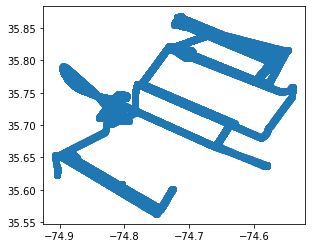

In [16]:
import geopandas as gpd

tsg_gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
tsg_gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

### Pull in FCM Data

In [51]:
fcm_df = pd.read_csv('data/sept_cruise/SW_fcm_full_bac_chla.csv')

In [52]:
date_time_strs = fcm_df['Date'] + ' ' + fcm_df['Time (UTC)']
fcm_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]

In [53]:
fcm_df['utc_dt'] = fcm_df['datetime']
fcm_df  = fcm_df.set_index('utc_dt')

In [54]:
fcm_df = fcm_df.sort_index(ascending=True)

In [61]:
fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan

<ipython-input-61-a5003a0a14a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan


In [15]:
lats = []
lons = []
for i in range(len(fcm_df)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(fcm_df.iloc[i].datetime), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
fcm_df['lat'] = lats
fcm_df['lon'] = lons

In [69]:
fcm_df.columns

Index(['Sample#', 'Time (UTC)', 'Date', 'Syn/mL', 'SynA', 'SynB', 'Syn_Avg',
       'Peuks/mL', 'PeuksA', 'PeaksB', 'Peuks_Avg', 'PicoCyano/mL',
       'PicoCyanoA', 'PicoCyanoB', 'PicoCyano_Avg', 'Bacteria_Avg',
       'Bacteria_SD', 'Chla A', 'Chla B', 'Chla_Avg', 'datetime'],
      dtype='object')

## Pull in NCP Data

In [112]:
import scipy.io
fn = 'data/sept_cruise/Cncp_plot.mat'
mat = scipy.io.loadmat(fn)
for item in list(mat.keys()):
    if item not in ['__header__', '__version__', '__globals__']:
        df_ncp = pd.DataFrame(data=mat[item], columns=['time', 'NCP mmol C m-2 d-1'])
        
df_ncp['dt'] = pd.to_datetime(df_ncp.time-719529, unit='D')
df_ncp = df_ncp.set_index('dt')
df_ncp = df_ncp.sort_index(ascending=True)
df_ncp['datetime'] = pd.to_datetime(df_ncp.time-719529, unit='D')

In [113]:
df_ncp

time  NCP mmol C m-2 d-1  \
dt                                                                 
2021-09-04 22:58:00.000000512  738403.956944                 NaN   
2021-09-04 23:00:00.000003328  738403.958333                 NaN   
2021-09-04 23:02:00.000006144  738403.959722                 NaN   
2021-09-04 23:03:59.999999232  738403.961111                 NaN   
2021-09-04 23:06:00.000012032  738403.962500                 NaN   
...                                      ...                 ...   
2021-09-09 11:49:59.999995648  738408.493056                 NaN   
2021-09-09 11:52:00.000008448  738408.494444                 NaN   
2021-09-09 11:54:00.000001280  738408.495833                 NaN   
2021-09-09 11:56:00.000004352  738408.497222                 NaN   
2021-09-09 11:58:00.000007168  738408.498611                 NaN   

                                                   datetime  
dt                                                           
2021-09-04 22:58:00.000000512 2021-09-04 22:58:00.000000512  
2021-09-04 23:00:00.000003328 2021-09-04 23:00:00.000003328  
2021-09-04 23:02:00.000006144 2021-09-04 23:02:00.000006144  
2021-09-04 23:03:59.999999232 2021-09-04 23:03:59.999999232  
2021-09-04 23:06:00.000012032 2021-09-04 23:06:00.000012032  
...                                                     ...  
2021-09-09 11:49:59.999995648 2021-09-09 11:49:59.999995648  
2021-09-09 11:52:00.000008448 2021-09-09 11:52:00.000008448  
2021-09-09 11:54:00.000001280 2021-09-09 11:54:00.000001280  
2021-09-09 11:56:00.000004352 2021-09-09 11:56:00.000004352  
2021-09-09 11:58:00.000007168 2021-09-09 11:58:00.000007168  

[3271 rows x 3 columns]

In [116]:
cdom_df.columns

Index(['yyyy/mm/dd HH:MM:SS.fff', ' V'], dtype='object')

In [118]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
BacteriaAvgs = []
ChlaAvgs = []

cdomVolts = []

ncp_match = []

for i in range(len(tsg_df)):
    try:
        row = fcm_df.iloc[fcm_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        BacteriaAvgs.append(row.Bacteria_Avg)
        ChlaAvgs.append(row.Chla_Avg)
    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        BacteriaAvgs.append(np.nan)
        ChlaAvgs.append(np.nan)
        
    try:
        row = cdom_df.iloc[cdom_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        cdomVolts.append(row[' V'])

    except KeyError:
        cdomVolts.append(np.nan)
        
    try:
        row = df_ncp.iloc[df_ncp.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        ncp_match.append(row['NCP mmol C m-2 d-1'])

    except KeyError:
        ncp_match.append(np.nan)
        
    if i % 2000 == 0:
        print(i)
        
tsg_df['SynA'] = SynAs
tsg_df['PeuksA'] = PeuksAs
tsg_df['PicoCyanoA'] = PicoCyanoAs
tsg_df['BacteriaAvg'] = BacteriaAvgs
tsg_df['ChlaAvg'] = ChlaAvgs
tsg_df['cdomVolts'] = cdomVolts

tsg_df['NCP'] = ncp_match


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000


In [126]:
count = 0
for x,y in zip(np.unique(tsg_df.NCP, return_counts=True)[0], np.unique(tsg_df.NCP, return_counts=True)[1]):
    if not np.isnan(x):
#         print(y)
        count += 1
print(count)

885


## Calculate density along the transect

In [129]:
import gsw

In [131]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP'],
      dtype='object')

In [161]:
tsg_df['sigma'] = gsw.density.sigma1(tsg_df.Temp, tsg_df.Sal)

In [134]:
tn_names = ['transect_1', 'transect_2', 'transect_3', 'transect_4', 'transect_5', 'transect_6', 'transect_7', 'transect_8', 'transect_9']

In [135]:
# bad practice but they're too noisy
import warnings
warnings.filterwarnings("ignore")

In [137]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP',
       'sigma'],
      dtype='object')

In [ ]:
df[df['name'].notnull()]

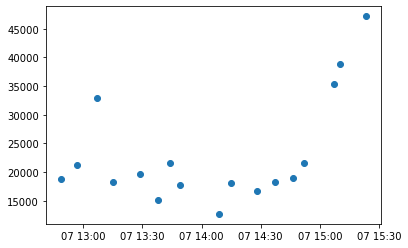

In [151]:
plt.scatter(tsg_df.loc[start_times[i]:end_times[i]]['SynA'].index, tsg_df.loc[start_times[i]:end_times[i]]['SynA'][tsg_df.loc[start_times[i]:end_times[i]]['SynA'].notnull()])

In [270]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']


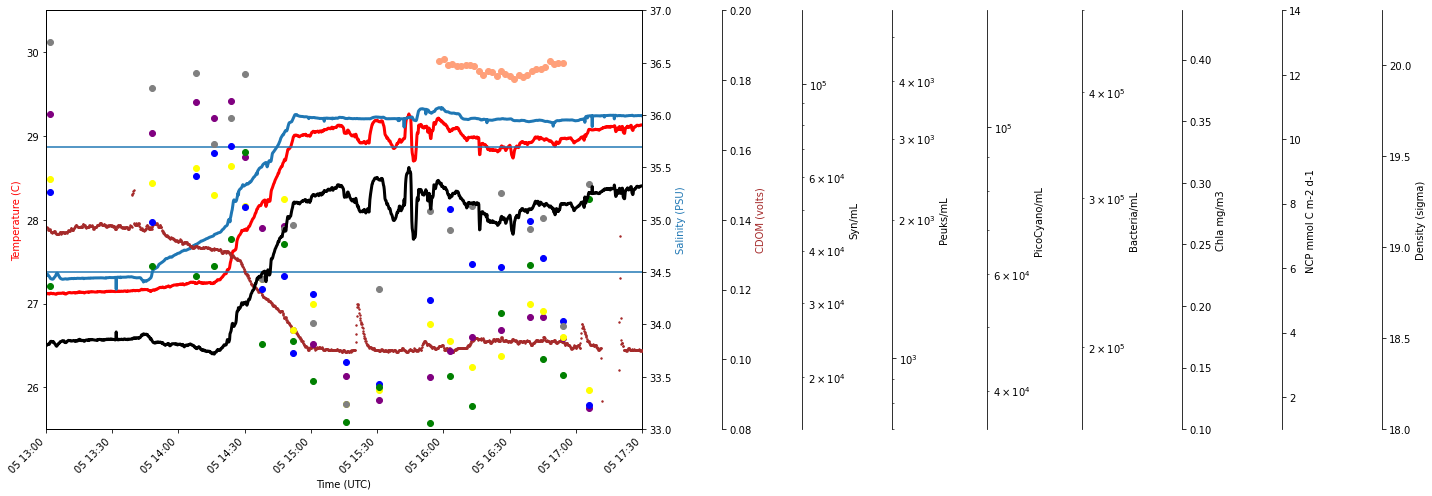

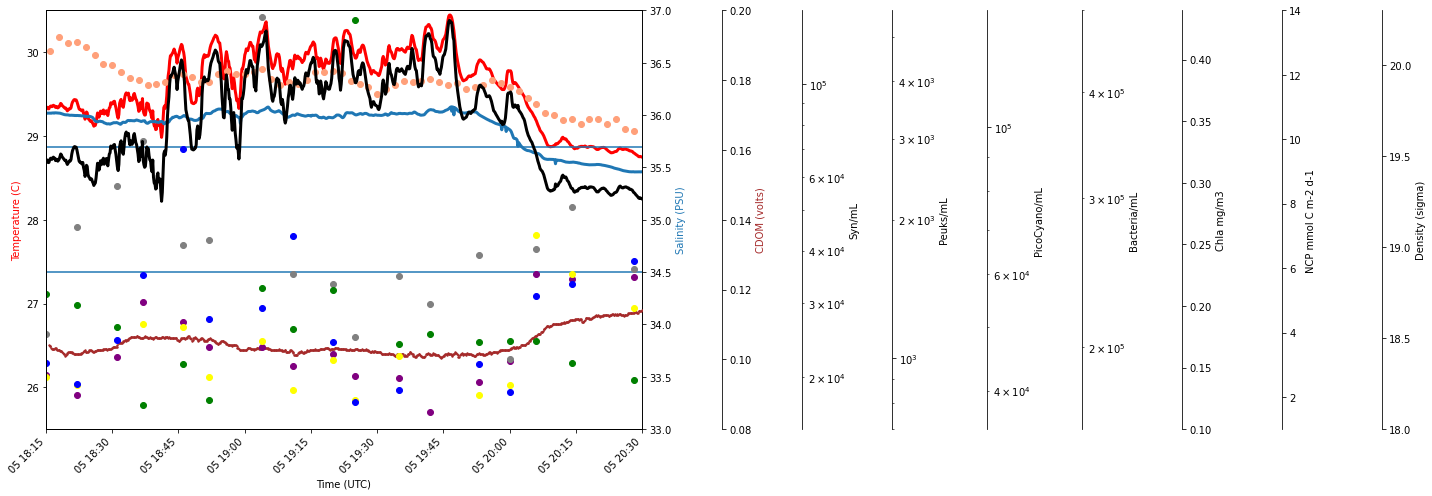

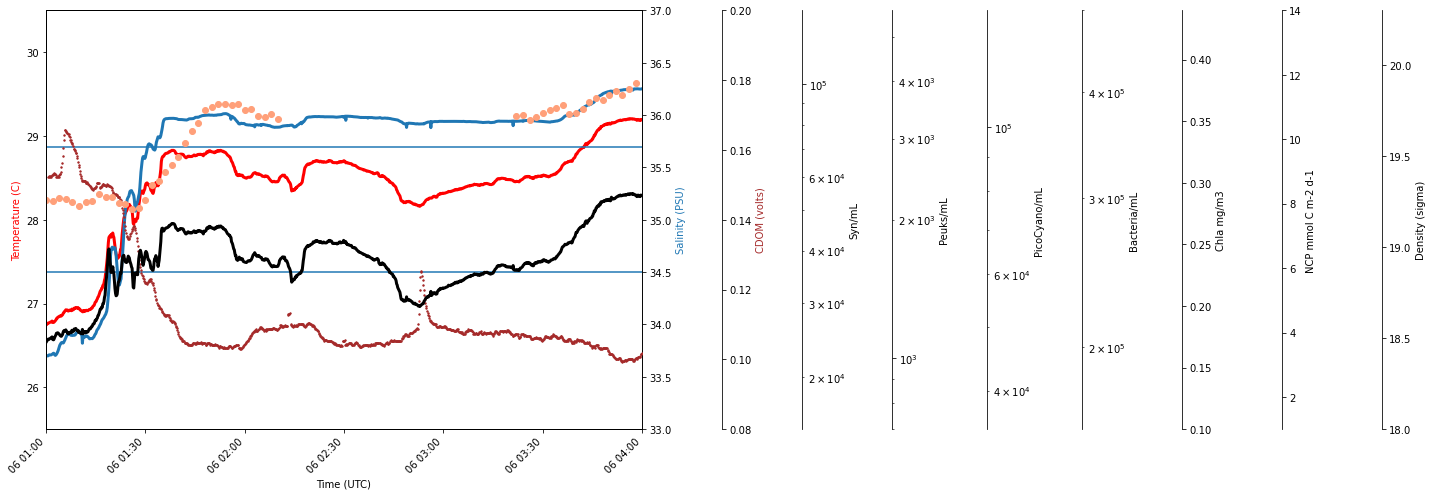

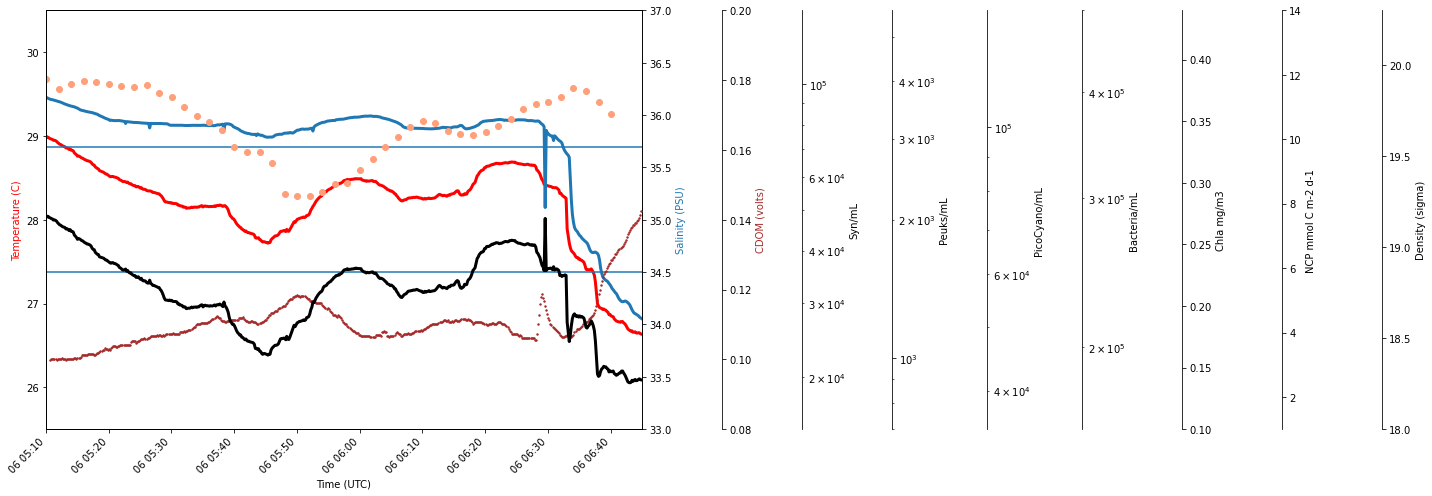

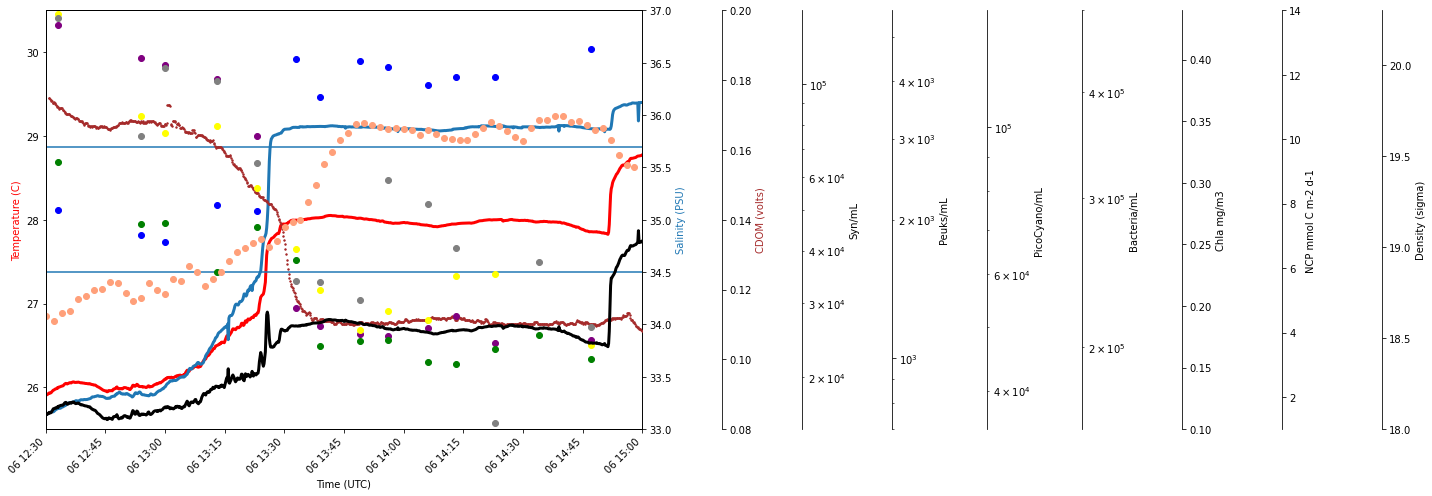

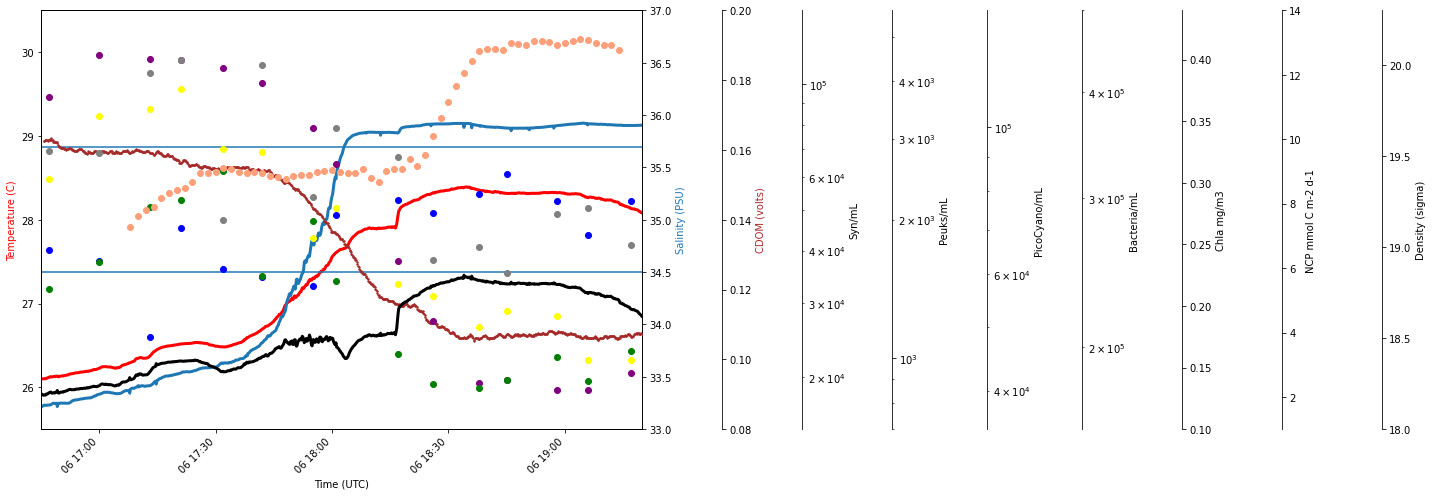

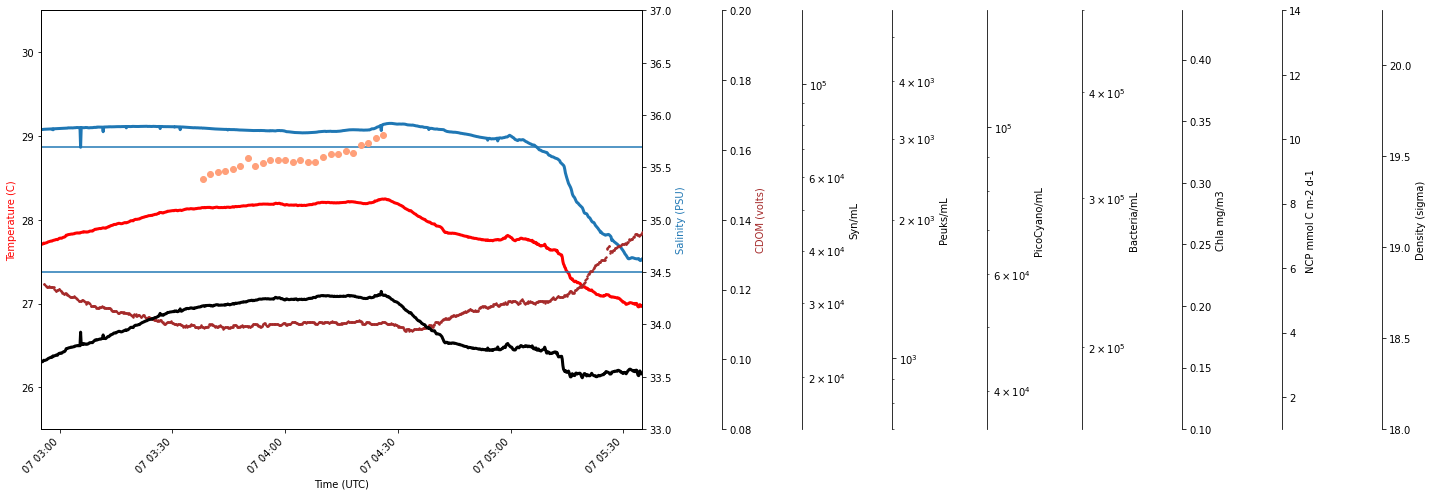

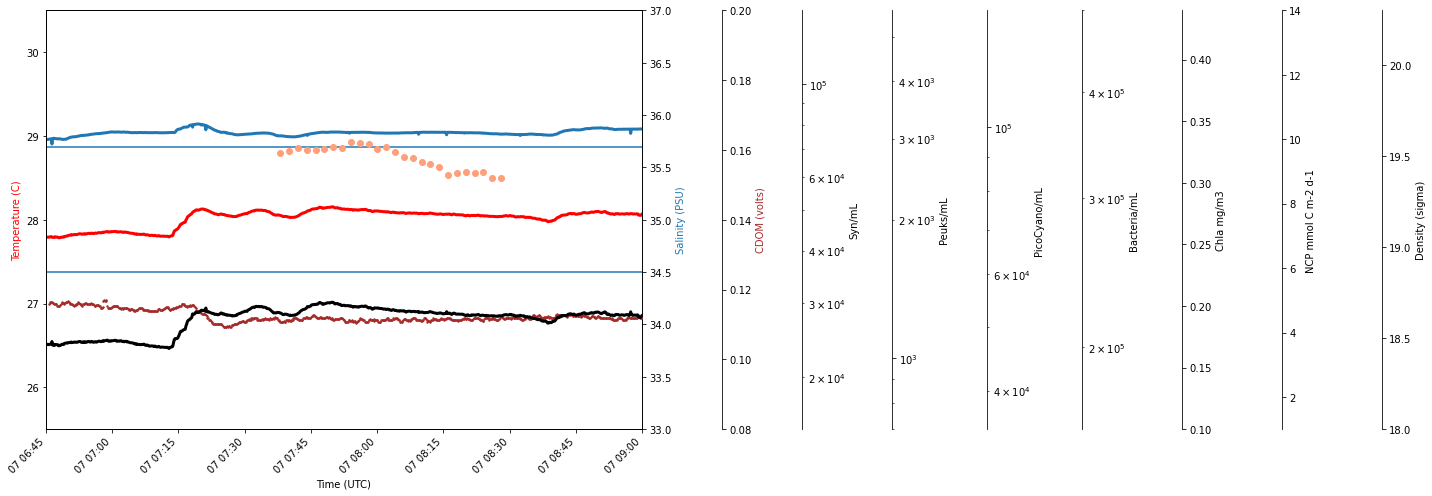

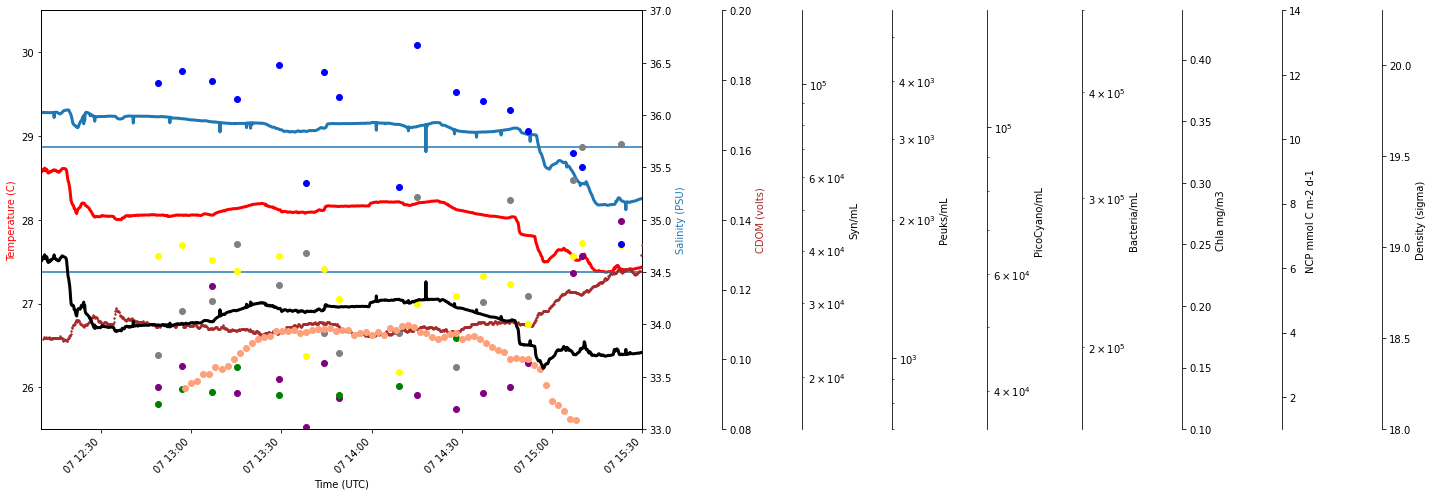

In [360]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

for i in range(9):
        # time series plot
        fig, ax = plt.subplots(figsize=(20,7))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()
        ax7 = ax.twinx()
        ax8 = ax.twinx()
        ax9 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)
        ax1.axhline(35.7)
        ax1.axhline(34.5)
        ax2.set_ylim(.08, .2)
        ax3.set_ylim(15000, 150000)
        ax4.set_ylim(700, 5700)
        ax5.set_ylim(35000, 150000)
        ax6.set_ylim(160000, 500000)
        ax7.set_ylim(.1, .44)
        ax8.set_ylim(1, 14)
        ax9.set_ylim(18, 20.3)
    
        ax.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
        
        ax3.set_yscale('log')
        ax4.set_yscale('log')
        ax5.set_yscale('log')
        ax6.set_yscale('log')

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Syn/mL")
        ax4.set_ylabel("Peuks/mL")
        ax5.set_ylabel("PicoCyano/mL")
        ax6.set_ylabel("Bacteria/mL")
        ax7.set_ylabel("Chla mg/m3")
        ax8.set_ylabel('NCP mmol C m-2 d-1')
        ax9.set_ylabel('Density (sigma)')

        p1, = ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', lw=3)
        p10, = ax9.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)', lw=3, color='black')

        p3 = ax2.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]].rolling(window=5).mean()['cdomVolts'], color='brown', label='CDOM', s=2)

        p4 = ax3.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='purple')
        p5 = ax4.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='yellow')
        p6 = ax5.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='blue')
        p7 = ax6.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='grey')
        p8 = ax7.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['ChlaAvg'], label='Chla mg/m3', color='green')    
        p9 = ax8.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['NCP'], label='NCP mmol C m-2 d-1', color='lightsalmon')    
         
        
#         ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 80))
        ax3.spines['right'].set_position(('outward', 160))
        ax4.spines['right'].set_position(('outward', 250))
        ax5.spines['right'].set_position(('outward', 345))
        ax6.spines['right'].set_position(('outward', 440))
        ax7.spines['right'].set_position(('outward', 540))
        ax8.spines['right'].set_position(('outward', 640))
        ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

# Now let's divide it up into front, eddy, and shelf water via salinity

In [202]:
tsg_df['water_mass'] = 'front'

In [203]:
tsg_df['water_mass'][tsg_df.Sal > 35.7] = 'eddy'
tsg_df['water_mass'][tsg_df.Sal < 34.6] = 'shelf'

In [204]:
np.unique(tsg_df.water_mass)

array(['eddy', 'front', 'shelf'], dtype=object)

In [205]:
np.mean(tsg_df[tsg_df.water_mass == 'eddy'].Temp), np.mean(tsg_df[tsg_df.water_mass == 'eddy'].sigma)

(28.07571609880754, 18.604233795722795)

In [206]:
np.mean(tsg_df[tsg_df.water_mass == 'eddy'].ChlaAvg)

0.16744038461538466

In [207]:
np.mean(tsg_df[tsg_df.water_mass == 'shelf'].Temp), np.mean(tsg_df[tsg_df.water_mass == 'shelf'].sigma)

(26.5064117904589, 18.27201072641487)

In [209]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP',
       'sigma', 'water_mass'],
      dtype='object')

In [214]:
tsg_df[tsg_df.water_mass == water_mass][col]

Series([], Name: NCP, dtype: float64)

In [216]:
water_mass

'shelf, front, eddy'

In [241]:
tsg_df_subset = tsg_df.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00']

In [261]:
start_times

['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 1:00:00',
 '2021-09-6 5:10:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 2:55:00',
 '2021-09-7 6:45:00',
 '2021-09-7 12:10:00']

In [412]:
end_times

['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 4:00:00',
 '2021-09-6 6:45:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 5:35:00',
 '2021-09-7 9:00:00',
 '2021-09-7 15:30:00']

In [431]:
start_times = [
 '2021-09-5 13:00:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00']

In [432]:
end_times = [
 '2021-09-5 17:30:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00']

In [421]:
start_times = [
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

In [422]:
end_times = [
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 15:30:00']

In [433]:
start_times[i],end_times[i]

('2021-09-5 13:00:00', '2021-09-5 17:30:00')

In [435]:
dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [424]:
tsg_df_subset.head()

Temp      Sal  Unknown                datetime  \
utc_dt                                                                       
2021-09-06 12:30:02.706  25.9059  33.1359  1534.89 2021-09-06 12:30:02.706   
2021-09-06 12:30:12.697  25.9132  33.1396  1534.91 2021-09-06 12:30:12.697   
2021-09-06 12:30:22.708  25.9121  33.1422  1534.91 2021-09-06 12:30:22.708   
2021-09-06 12:30:32.693  25.9222  33.1477  1534.94 2021-09-06 12:30:32.693   
2021-09-06 12:30:42.702  25.9259  33.1550  1534.96 2021-09-06 12:30:42.702   

                               lat        lon                    geometry  \
utc_dt                                                                      
2021-09-06 12:30:02.706  35.863118 -74.705477  POINT (-74.70548 35.86312)   
2021-09-06 12:30:12.697  35.863055 -74.705323  POINT (-74.70532 35.86306)   
2021-09-06 12:30:22.708  35.862985 -74.705153  POINT (-74.70515 35.86299)   
2021-09-06 12:30:32.693  35.862893 -74.705002  POINT (-74.70500 35.86289)   
2021-09-06 12:30:42.702  35.862817 -74.704818  POINT (-74.70482 35.86282)   

                         SynA  PeuksA  PicoCyanoA  BacteriaAvg  ChlaAvg  \
utc_dt                                                                    
2021-09-06 12:30:02.706   NaN     NaN         NaN          NaN      NaN   
2021-09-06 12:30:12.697   NaN     NaN         NaN          NaN      NaN   
2021-09-06 12:30:22.708   NaN     NaN         NaN          NaN      NaN   
2021-09-06 12:30:32.693   NaN     NaN         NaN          NaN      NaN   
2021-09-06 12:30:42.702   NaN     NaN         NaN          NaN      NaN   

                         cdomVolts       NCP      sigma water_mass  
utc_dt                                                              
2021-09-06 12:30:02.706      0.175  4.501559  18.079627      shelf  
2021-09-06 12:30:12.697      0.175       NaN  18.083548      shelf  
2021-09-06 12:30:22.708      0.175       NaN  18.081831      shelf  
2021-09-06 12:30:32.693      0.175       NaN  18.087120      shelf  
2021-09-06 12:30:42.702      0.174       NaN  18.087172      shelf

In [267]:
len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='shelf']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='front']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df['water_mass']=='eddy'])

(11, 5, 29)

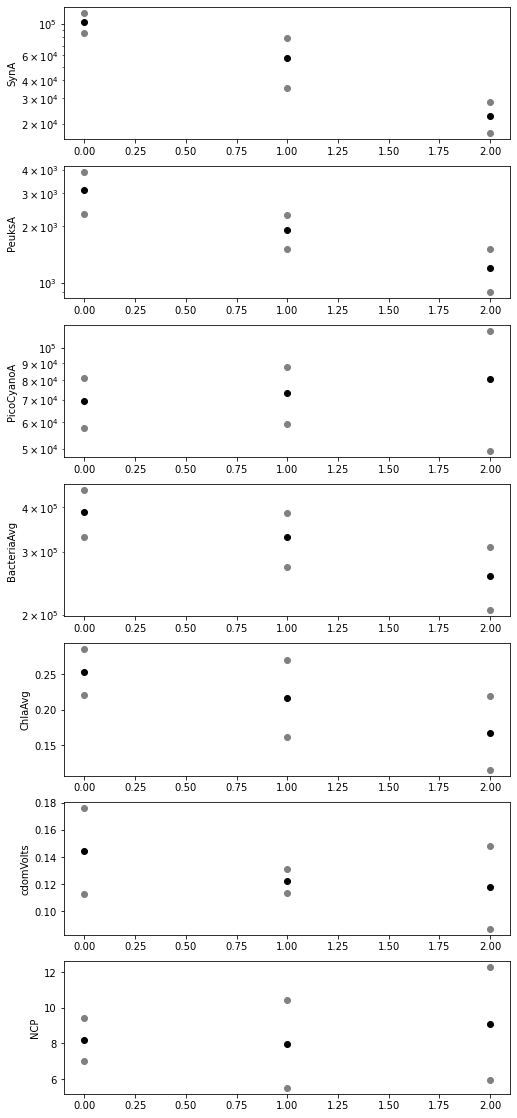

In [436]:
columns_to_plot = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']
scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']

fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,20))


for i, water_mass in enumerate(['shelf', 'front', 'eddy']):
    for j, col in enumerate(columns_to_plot):
        ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col]), color='black')
        ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])+np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
        ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])-np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
        ax[j].set_yscale(scale_to_plot[j])
        ax[j].set_ylabel(col)

(0.08, 0.2)

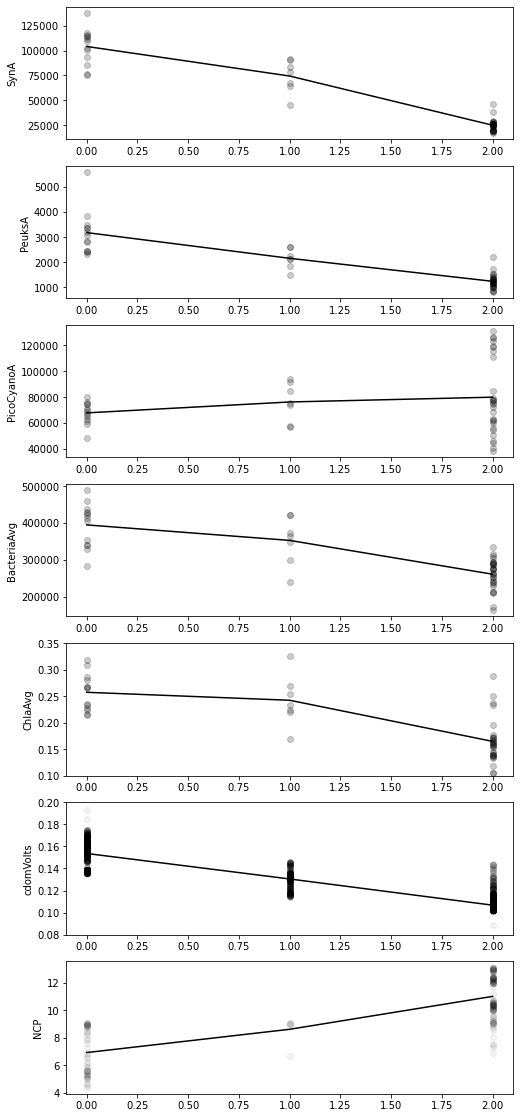

In [437]:
columns_to_plot = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']
scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']
alpha_to_plot = [.2,.2,.2,.2,.2,.05,.05]

fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,20))

water_masses = ['shelf', 'front', 'eddy']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot):
        ax[j].scatter(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i], tsg_df_subset[tsg_df_subset.water_mass == water_mass][col], color='black', alpha=alpha_to_plot[j])
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot):
    means = []
    for wm in water_masses:
        means.append(np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)

ax[4].set_ylim(0.1,0.35)
ax[5].set_ylim(0.08,0.2)

In [345]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [354]:
columns_to_plot

['SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']

In [441]:
# Create linear regression object
regr = linear_model.LinearRegression()

target='PicoCyanoA'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

# Train the model using the training sets
regr.fit(X, y)

LinearRegression()

In [442]:
X.shape, y.shape

((48, 2), (48,))

In [443]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
# x = StandardScaler().fit_transform(x)

Coefficients: 
 [-57837.48929619  58365.37910202]
Mean squared error: 12341.21
Coefficient of determination: 0.73


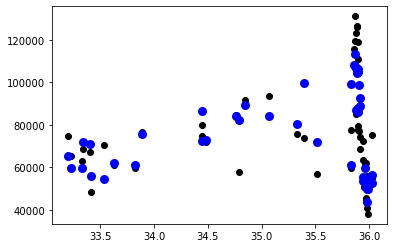

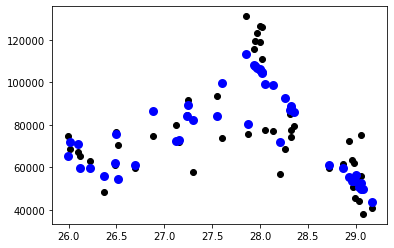

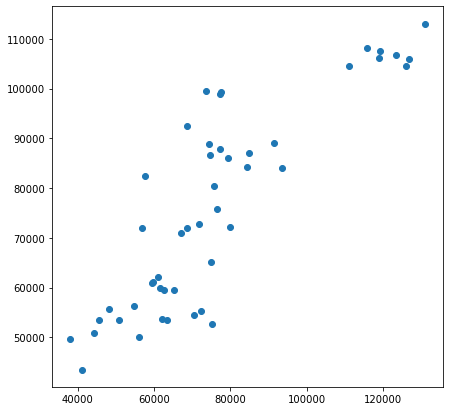

In [445]:
# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X[:,1], y, color="black")
plt.scatter(X[:,1], y_pred, color="blue", linewidth=3)
plt.show()

# Plot outputs
plt.scatter(X[:,0], y, color="black")
plt.scatter(X[:,0], y_pred, color="blue", linewidth=3)
plt.show()

fig,ax=plt.subplots(figsize=(7,7))
plt.scatter(y, y_pred)
plt.show()
# plt.xticks(())
# plt.yticks(())



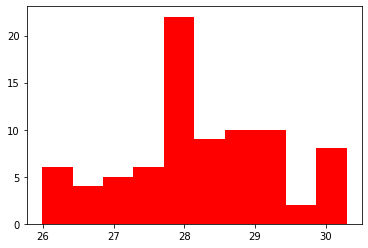

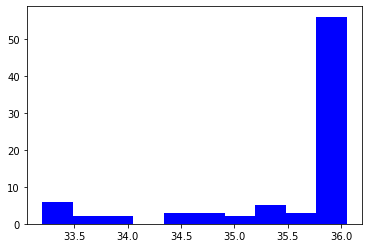

In [324]:
plt.hist(X[:,0], color='red')
plt.show()
plt.hist(X[:,1], color='blue')
plt.show()
# plt.hist(X[:,2], color='brown')
# plt.show()

In [370]:
! pip install pygam

     |████████████████████████████████| 1.8 MB 1.5 MB/s eta 0:00:01


In [393]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP',
       'sigma', 'water_mass'],
      dtype='object')

In [456]:
target='NCP'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

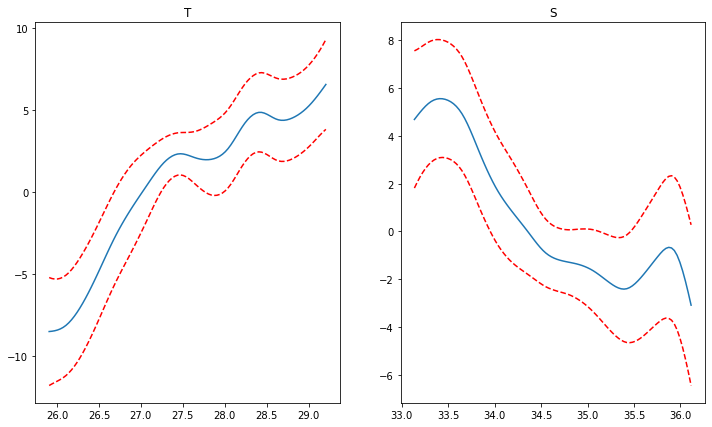

In [457]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

# X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,2, figsize=(12,7));

titles = ['T', 'S']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     if i == 2:
#         ax.set_xlim(0,.4)
    ax.set_title(titles[i]);